# Automate hand-written tabular content using Amazon Textract and Amazon A2I
Organizations across industries have a large number of hand-written documents that require processing as part of their operations. Extracting data from these documents especially when there is a combination of printed and handwritten text is error-prone, time-consuming, expensive, and does not scale. Text being embedded in tables and forms adds to the extraction and processing complexity. Amazon Textract is a fully managed ML service that automatically extracts printed text, handwriting, and other data from scanned documents that goes beyond simple optical character recognition (OCR) to identify, understand, and extract data from forms and tables.

Once the data and text is extracted, the post processing step in a document management workflow involves reviewing the entries and make changes as needed. Amazon A2I makes it easy to integrate a human review into your ML workflow. This allows you to automatically have humans step into your ML pipeline to review results below a confidence threshold, set up review and auditing workflows, and augment the prediction results to improve model accuracy

In this notebook we show you how to use Amazon Textract to extract the content of your forms containing hand-written text, setup and send to a human review loop, and augment the extracted invoice content for downstream processing.

* Step 0 - Install and import libraries
* Step 1 - Use Amazon Textract to retrieve form content
* Step 2 - Inspect and analyze form line items
* Step 3 - Send to Amazon A2I human loop
* Step 4 - Augment the forms
* Step 5 - Store the augmented forms for downstream processing

In [5]:
# install trp
!pip install amazon-textract-response-parser

In [6]:
import pandas as pd
import webbrowser, os
import json
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
from sagemaker.s3 import S3Uploader, S3Downloader
import uuid
import time
import io
from io import BytesIO
import sys
import csv
from pprint import pprint
from IPython.display import Image, display
from PIL import Image as PImage, ImageDraw

### Setup a private review workforce

This step requires you to use the AWS Console. However, we highly recommend that you follow it, especially when creating your own task with a custom template we will use for this notebook. We will create a private workteam and add only one user (you) to it.

To create a private team:

   1. Go to AWS Console > Amazon SageMaker > Labeling workforces
   1. Click "Private" and then "Create private team".
   1. Enter the desired name for your private workteam.
   1. Enter your own email address in the "Email addresses" section.
   1. Enter the name of your organization and a contact email to administer the private workteam.
   1. Click "Create Private Team".
   1. The AWS Console should now return to AWS Console > Amazon SageMaker > Labeling workforces. Your newly created team should be visible under "Private teams". Next to it you will see an ARN which is a long string that looks like arn:aws:sagemaker:region-name-123456:workteam/private-crowd/team-name. Please copy this ARN to paste in the cell below.
   1. You should get an email from no-reply@verificationemail.com that contains your workforce username and password.
   1. In AWS Console > Amazon SageMaker > Labeling workforces, click on the URL in Labeling portal sign-in URL. Use the email/password combination from Step 8 to log in (you will be asked to create a new, non-default password).
   1. This is your private worker's interface. When we create a verification task in Verify your task using a private team below, your task should appear in this window. You can invite your colleagues to participate in the labeling job by clicking the "Invite new workers" button.

Please refer to the Amazon SageMaker documentation if you need more details.

In [7]:
# Enter the Workteam ARN from step 7 above
WORKTEAM_ARN= 'arn:aws:sagemaker:us-east-1:905418298175:workteam/private-crowd/SafeDocs'
 
# Define IAM role
role = get_execution_role()
print("RoleArn: {}".format(role))
sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = 'textract-a2i-handwritten'

RoleArn: arn:aws:iam::905418298175:role/TextractA2I1-SageMakerIamRole-8OXVNh9exih8


## Step 1 - Use Amazon Textract to retrieve document content and inspect response

In this step, we will download our test invoice from a S3 bucket to our notebook instance, and then use Amazon Textract to read the hand-written content present in the invoice line items table, and load this into a pandas dataframe for analysis.

#### Review the sample document which has both printed and handwritten content in the tables

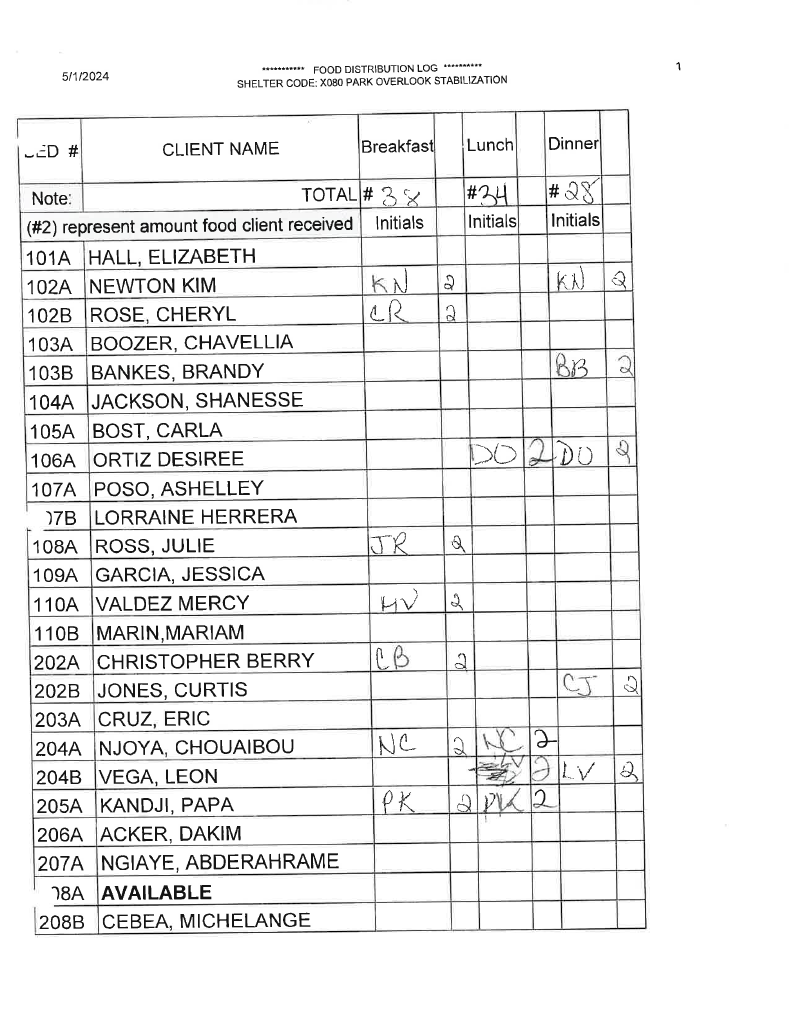

In [8]:
# Document
documentName = "test_handwritten_document.png"

display(Image(filename=documentName))

### Helper functions to parse Amazon Textract response

We will now import the Amazon Textract Response Parser library to parse and extract what we need from Amazon Textract's response. There are two main functions here. One, we will extract the header data containing the document heading, and the form data (key-value pairs) part of the header section of the document. Two, we will parse the table and cells to create a csv file containing the tabular data. In this notebook, we will use the Textract Sync API for document extraction, [AnalyzeDocument](https://docs.aws.amazon.com/textract/latest/dg/API_AnalyzeDocument.html). This accepts image files (png or jpeg) as an input. For example, here is the code snippet for AnalyzeDocument:
    
    client = boto3.client(
         service_name='textract',
         region_name= 'us-east-1',
         endpoint_url='https://textract.us-east-1.amazonaws.com',)
         
    response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['TABLES','FORMS'])

Alternatively, if you would like to modify this notebook to use a PDF file or for batch processing of documents, use the [StartDocumentAnalysis API](https://docs.aws.amazon.com/textract/latest/dg/API_StartDocumentAnalysis.html). StartDocumentAnalysis returns a job identifier (JobId) that you use to get the results of the operation. When text analysis is finished, Amazon Textract publishes a completion status to the Amazon Simple Notification Service (Amazon SNS) topic that you specify in NotificationChannel. To get the results of the text analysis operation, first check that the status value published to the Amazon SNS topic is SUCCEEDED. If so, call GetDocumentAnalysis, and pass the job identifier (JobId) from the initial call to StartDocumentAnalysis.

In [9]:
client = boto3.client(
         service_name='textract',
         region_name= 'us-east-1',
         endpoint_url='https://textract.us-east-1.amazonaws.com',
)

In [10]:
with open(documentName, 'rb') as file:
        img_test = file.read()
        bytes_test = bytearray(img_test)
        print('Image loaded', documentName)

Image loaded test_handwritten_document.png


In [11]:
# process using image bytes
response = client.analyze_document(Document={'Bytes': bytes_test}, FeatureTypes=['TABLES','FORMS'])

You can use Textract response parser library to easily parser JSON returned by Amazon Textract. Library parses JSON and provides programming language specific constructs to work with different parts of the document. For more details please refer to the [Amazon Textract Parser Library](https://github.com/aws-samples/amazon-textract-response-parser/tree/master/src-python)

In [12]:
from trp import Document
# Parse JSON response from Textract
doc = Document(response)

# Iterate over elements in the document
for page in doc.pages:
    # Print lines and words
    for line in page.lines:
        print("Line: {}".format(line.text))
        for word in line.words:
            print("Word: {}".format(word.text))

    # Print tables
    for table in page.tables:
        for r, row in enumerate(table.rows):
            for c, cell in enumerate(row.cells):
                print("Table[{}][{}] = {}".format(r, c, cell.text))

    # Print fields
    for field in page.form.fields:
        print("Field: Key: {}, Value: {}".format(field.key, field.value))



Line: FOOD DISTRIBUTION LOG
Word: FOOD
Word: DISTRIBUTION
Word: LOG
Line: 1
Word: 1
Line: 5/1/2024
Word: 5/1/2024
Line: SHELTER CODE: X080 PARK OVERLOOK STABILIZATION
Word: SHELTER
Word: CODE:
Word: X080
Word: PARK
Word: OVERLOOK
Word: STABILIZATION
Line: CED #
Word: CED
Word: #
Line: CLIENT NAME
Word: CLIENT
Word: NAME
Line: Breakfast
Word: Breakfast
Line: Lunch
Word: Lunch
Line: Dinner
Word: Dinner
Line: Note:
Word: Note:
Line: TOTAL
Word: TOTAL
Line: #38
Word: #38
Line: #34
Word: #34
Line: # 28
Word: #
Word: 28
Line: (#2) represent amount food client received
Word: (#2)
Word: represent
Word: amount
Word: food
Word: client
Word: received
Line: Initials
Word: Initials
Line: Initials
Word: Initials
Line: Initials
Word: Initials
Line: 101A
Word: 101A
Line: HALL, ELIZABETH
Word: HALL,
Word: ELIZABETH
Line: 102A
Word: 102A
Line: NEWTON KIM
Word: NEWTON
Word: KIM
Line: KN
Word: KN
Line: 2
Word: 2
Line: KN
Word: KN
Line: 2
Word: 2
Line: 102B
Word: 102B
Line: ROSE, CHERYL
Word: ROSE,
Word: C

Now that we have the contents we need from the document image, let's create a csv file to store it and also use it for setting up the Amazon A2I human loop for review and modification as needed.

In [13]:
# Lets get the form data into a csv file
with open('test_handwritten_form.csv', 'w', newline='') as csvfile:
    formwriter = csv.writer(csvfile, delimiter=',',
                            quoting=csv.QUOTE_MINIMAL)
    for field in page.form.fields:
        formwriter.writerow([str(field.key)+" "+str(field.value)])

In [14]:
# Lets get the table data into a csv file
with open('test_handwritten_tab.csv', 'w', newline='') as csvfile:
    tabwriter = csv.writer(csvfile, delimiter=',')
    for r, row in enumerate(table.rows):
        csvrow = []
        for c, cell in enumerate(row.cells):
            if cell.text:
                csvrow.append(cell.text.rstrip())
                #csvrow += '{}'.format(cell.text.rstrip())+","
        tabwriter.writerow(csvrow)              

In [15]:
# Return the URLs of the uploaded file, so they can be reviewed or used elsewhere
s3_img_url = S3Uploader.upload('test_handwritten_document.png', 's3://{}/{}'.format(bucket, prefix))

## Step 2 - Inspect and analyze form line items

We will now load the form line items into a pandas dataframe, and clean it up to ensure we have the relevant columns and rows that downstream applications need. We will then send it to Amazon A2I for human review, and augmentation.

In [16]:
# Load the csv file contents into a dataframe, strip out extra spaces, use comma as delimiter
df_form = pd.read_csv('test_handwritten_form.csv', header=None, quoting=csv.QUOTE_MINIMAL, sep=',')
# Rename column
df_form = df_form.rename(columns={df_form.columns[0]: 'FormHeader'})
# display the dataframe
df_form

,FormHeader
0,Breakfast None
1,CLIENT NAME None
2,Lunch #34
3,TOTAL #38
4,Note: None
5,SHELTER CODE: X080 PARK OVERLOOK STABILIZATION
6,Dinner # 28
7,CED # None
8,08A AVAILABLE


In [17]:
# Load the csv file contents into a dataframe, strip out extra spaces, use comma as delimiter
# Add , on_bad_lines='skip' after limitter
df_tab = pd.read_csv('test_handwritten_tab.csv', header=0, quoting=csv.QUOTE_MINIMAL, sep=',', on_bad_lines='skip')
# display the dataframe
df_tab.head()

,CED #,CLIENT NAME,Breakfast,Lunch,Dinner
0,Note:,TOTAL,#38,#34,# 28
1,(#2),represent amount food client received,Initials,Initials,Initials
2,101A,"HALL, ELIZABETH",NaN,NaN,NaN
3,102B,"ROSE, CHERYL",CR,2,NaN
4,103A,"BOOZER, CHAVELLIA",NaN,NaN,NaN


# Step 3 - Setting up Amazon A2I human loop to review Textract's low confidence responses

In this step, we will send the form line items in a tabular form to an Amazon A2I human loop for review, and modifications/augmentation to the data as required. Once this is done, we will persist this updated data in a DynamoDB table so downstream applications can use for processing.

In [18]:
timestamp = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
# Amazon SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Amazon Augment AI (A2I) client
a2i = boto3.client('sagemaker-a2i-runtime')

# Amazon S3 client 
s3 = boto3.client('s3')

# Flow definition name - this value is unique per account and region. You can also provide your own value here.
flowDefinitionName = 'fd-hw-docs-' + timestamp

# Task UI name - this value is unique per account and region. You can also provide your own value here.
taskUIName = 'ui-hw-docs-' + timestamp

# Flow definition outputs
OUTPUT_PATH = f's3://' + sess.default_bucket() + '/' + prefix + '/a2i-results'

### Step 3b - Create the human task UI

Create a human task UI resource, giving a UI template in liquid html.You can download this tempalte and customize it https://github.com/aws-samples/amazon-textract-a2i-dynamodb-handwritten-tabular/blob/main/tables-keyvalue-sample.liquid.html
This template will be rendered to the human workers whenever human loop is required. For over 70 pre built UIs, check: https://github.com/aws-samples/amazon-a2i-sample-task-uis. But first, lets declare some variables that we need during the next set of steps.

In [19]:
# We customized the tabular template for our notebook as below
template = r"""
<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>

<style>
  table, tr, th, td {
    border: 1px solid black;
    border-collapse: collapse;
    padding: 5px;
  }
</style>

<crowd-form>
    <div>
        <h1>Instructions</h1>
        <p>Please review the form and table line items, and make corrections where appropriate. </p>
    </div>
   <div>
      <h3>Original Form</h3>
      <classification-target>
        <img style="width: 100%; max-height: 40%; margin-bottom: 10px" src="{{ task.input.image1 | grant_read_access }}"/>        
      </classification-target>     
   </div>
    <br>
    <h1> Enter your corrections below </h1>
    <table>
    <tr>
        <th>FORM LINE NR</th>
        <th>ORIGINAL FORM LINE</th>
        <th>CHANGE REQUIRED</th>
        <th>CORRECTED FORM LINE</th>
        <th>COMMENTS</th>
    </tr>
    {% for pair in task.input.Header %}

        <tr>
          <td>{{ pair.hdrrow }}</td>
          <td><crowd-text-area name="predictedhdr{{ forloop.index }}" value="{{ pair.orighdr }}"></crowd-text-area></td>     
          <td>
            <p>
              <input type="radio" id="agree{{ forloop.index }}" name="rating{{ forloop.index }}" value="agree" required>
              <label for="agree{{ forloop.index }}">Correct</label>
            </p>
            <p>
              <input type="radio" id="disagree{{ forloop.index }}" name="rating{{ forloop.index }}" value="disagree" required>
              <label for="disagree{{ forloop.index }}">Incorrect</label>
            </p>
          </td>
          <td>
            <p>
            <input type="text" name="TrueHdr{{ forloop.index }}" placeholder="Corrected Form Info" />
            </p>
           </td>
           <td>
            <p>
            <input type="text" name="Comments{{ forloop.index }}" placeholder="Explain why you changed the value" />
            </p>
           </td>
        </tr>

      {% endfor %}
    </table>
    <br>
    <br>
    <table>
      <tr>
        <th>LINE ITEM</th>
        <th>START DATE</th>
        <th>END DATE</th>
        <th>EMPLOYER NAME</th>
        <th>POSITION HELD</th>
        <th>REASON FOR LEAVING</th>
        <th>CHANGE REQUIRED</th>
        <th>TRUE START DATE</th>
        <th>TRUE END DATE</th>
        <th>TRUE EMPLOYER NAME</th>
        <th>TRUE POSITION HELD</th>
        <th>TRUE REASON FOR LEAVING</th>
        <th>COMMENTS</th>
      </tr>

      {% for pair in task.input.Pairs %}

        <tr>
          <td>{{ pair.row }}</td>
          <td><crowd-text-area name="predicted{{ forloop.index }}" value="{{ pair.startdate }}"></crowd-text-area></td>
          <td><crowd-text-area name="predicted{{ forloop.index }}" value="{{ pair.enddate }}"></crowd-text-area></td>
          <td><crowd-text-area name="predicted{{ forloop.index }}" value="{{ pair.empname }}"></crowd-text-area></td>
          <td><crowd-text-area name="predicted{{ forloop.index }}" value="{{ pair.posheld }}"></crowd-text-area></td>
          <td><crowd-text-area name="predicted{{ forloop.index }}" value="{{ pair.resleave }}"></crowd-text-area></td>
          <td>
            <p>
              <input type="radio" id="agreeline{{ forloop.index }}" name="ratingline{{ forloop.index }}" value="agree" required>
              <label for="agreeline{{ forloop.index }}">Correct</label>
            </p>
            <p>
              <input type="radio" id="disagreeline{{ forloop.index }}" name="ratingline{{ forloop.index }}" value="disagree" required>
              <label for="disagreeline{{ forloop.index }}">Incorrect</label>
            </p>
          </td>
          <td>
            <p>
            <input type="text" name="TrueStartDate{{ forloop.index }}" placeholder="Corrected Start Date" />
            </p>
           </td>
           <td>
            <p>
            <input type="text" name="TrueEndDate{{ forloop.index }}" placeholder="Corrected End Date" />
            </p>
           </td>
          <td>
            <p>
            <input type="text" name="TrueEmpName{{ forloop.index }}" placeholder="Corrected Employee Name" />
            </p>
           </td>
           <td>
            <p>
            <input type="text" name="TruePosHeld{{ forloop.index }}" placeholder="Corrected Position Held" />
            </p>
           </td>
           <td>
            <p>
            <input type="text" name="TrueResLeave{{ forloop.index }}" placeholder="Corrected Reason for Leaving" />
            </p>
           </td>
           <td>
            <p>
            <input type="text" name="Change Reason{{ forloop.index }}" placeholder="Explain why you changed the value" />
            </p>
           </td>
        </tr>

      {% endfor %}

    </table>
</crowd-form>
"""



After creating this custom template using HTML, you must use this template to generate an Amazon A2I human task UI Amazon Resource Name (ARN) .This ARN has the following format: arn:aws:sagemaker:<aws-region>:<aws-account-number>:human-task-ui/<template-name>. This ARN is associated with a worker task template resource that you can use in one or more human review workflows (flow definitions).Generate a human task UI ARN using a worker task template by using the CreateHumanTaskUi API operation by running the notebook cell below:

In [20]:
def create_task_ui():
    '''
    Creates a Human Task UI resource.

    Returns:
    struct: HumanTaskUiArn
    '''
    response = sagemaker_client.create_human_task_ui(
        HumanTaskUiName=taskUIName,
        UiTemplate={'Content': template})
    return response

In [21]:
# Create task UI
humanTaskUiResponse = create_task_ui()
humanTaskUiArn = humanTaskUiResponse['HumanTaskUiArn']
print(humanTaskUiArn)

arn:aws:sagemaker:us-east-1:905418298175:human-task-ui/ui-hw-docs-2024-07-29-19-45-43


### Step 3b - Create the Flow Definition
In this section, we're going to create a flow definition definition. Flow Definitions allow us to specify:

* The workforce that your tasks will be sent to.
* The instructions that your workforce will receive. This is called a worker task template.
* Where your output data will be stored.
* This demo is going to use the API, but you can optionally create this workflow definition in the console as well. 

For more details and instructions, see: https://docs.aws.amazon.com/sagemaker/latest/dg/a2i-create-flow-definition.html.

In [22]:
create_workflow_definition_response = sagemaker_client.create_flow_definition(
        FlowDefinitionName= flowDefinitionName,
        RoleArn= role,
        HumanLoopConfig= {
            "WorkteamArn": WORKTEAM_ARN,
            "HumanTaskUiArn": humanTaskUiArn,
            "TaskCount": 1,
            "TaskDescription": "Review the contents and correct values as indicated",
            "TaskTitle": "Employment History Review"
        },
        OutputConfig={
            "S3OutputPath" : OUTPUT_PATH
        }
    )
flowDefinitionArn = create_workflow_definition_response['FlowDefinitionArn'] # let's save this ARN for future use

In [23]:
for x in range(60):
    describeFlowDefinitionResponse = sagemaker_client.describe_flow_definition(FlowDefinitionName=flowDefinitionName)
    print(describeFlowDefinitionResponse['FlowDefinitionStatus'])
    if (describeFlowDefinitionResponse['FlowDefinitionStatus'] == 'Active'):
        print("Flow Definition is active")
        break
    time.sleep(2)

Initializing
Active
Flow Definition is active


# Sending predictions to Amazon A2I human loops

In [ ]:
NUM_TO_REVIEW = len(df_tab) # number of line items to review
dfstart = df_tab['Breakfast'].to_list()
dfend = df_tab['Lunch'].to_list()
dfemp = df_tab['Dinner'].to_list()

item_list = [{'row': "{}".format(x), 'Breakfast': dfstart[x], 'Lunch': dfend[x], 'Dinner': dfemp[x], } for x in range(NUM_TO_REVIEW)]
item_list


# Function to recursively replace NaN values with None
def replace_nan(obj):
    if isinstance(obj, dict):
        return {k: replace_nan(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [replace_nan(i) for i in obj]
    elif isinstance(obj, float) and np.isnan(obj):
        return None
    else:
        return obj

In [ ]:
dforighdr = df_form['FormHeader'].to_list()
hdr_list = [{'hdrrow': "{}".format(x), 'orighdr': dforighdr[x]} for x in range(len(df_form))]
hdr_list

In [ ]:
ip_content = {"Header": hdr_list,
              'Pairs': item_list,
              'image1': s3_img_url
             }

In [ ]:
import json
import uuid
import math

# Define a function to remove NaN from the content
def remove_nan(content):
    if isinstance(content, dict):
        return {k: remove_nan(v) for k, v in content.items() if not (isinstance(v, float) and math.isnan(v))}
    elif isinstance(content, list):
        return [remove_nan(item) for item in content if not (isinstance(item, float) and math.isnan(item))]
    elif isinstance(content, float) and math.isnan(content):
        return None  # or any placeholder you prefer for NaN
    return content

# Remove NaN from the input content
filtered_ip_content = remove_nan(ip_content)

# Convert filtered content to JSON
filtered_ip_content_json = json.dumps(filtered_ip_content)

# Activate human loops
humanLoopName = str(uuid.uuid4())

start_loop_response = a2i.start_human_loop(
    HumanLoopName=humanLoopName,
    FlowDefinitionArn=flowDefinitionArn,
    HumanLoopInput={
        "InputContent": filtered_ip_content_json
    }
)

Check status of human loop

In [ ]:
completed_human_loops = []
resp = a2i.describe_human_loop(HumanLoopName=humanLoopName)
print(f'HumanLoop Name: {humanLoopName}')
print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
print('\n')
   
      
if resp["HumanLoopStatus"] == "Completed":
    completed_human_loops.append(resp)

In [ ]:
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker_client.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

In [ ]:
completed_human_loops = []
resp = a2i.describe_human_loop(HumanLoopName=humanLoopName)
print(f'HumanLoop Name: {humanLoopName}')
print(f'HumanLoop Status: {resp["HumanLoopStatus"]}')
print(f'HumanLoop Output Destination: {resp["HumanLoopOutput"]}')
print('\n')
    
if resp["HumanLoopStatus"] == "Completed":
    completed_human_loops.append(resp)

#### Let's review the annotation output

In [ ]:
import re
import pprint

pp = pprint.PrettyPrinter(indent=4)

for resp in completed_human_loops:
    splitted_string = re.split('s3://' + sess.default_bucket()  + '/', resp['HumanLoopOutput']['OutputS3Uri'])
    output_bucket_key = splitted_string[1]
    response = s3.get_object(Bucket=bucket, Key=output_bucket_key)
    content = response["Body"].read()
    json_output = json.loads(content)
    pp.pprint(json_output)
    print('\n')

## Step 5 - Store the results in DynamoDB

We will now store the form with updated contents into a DynamoDB table, so downstream applications can make use of it. To automate the process, simply setup an [AWS Lambda trigger with DynamoDB](https://docs.aws.amazon.com/amazondynamodb/latest/developerguide/Streams.Lambda.html), to automatically extract and send information to your API endpoints or applications.

#### First let's append the changed values to the existing dataframe we used for analysis

In [ ]:
df_form

In [ ]:
df_tab.head()

In [ ]:
#updated array values to be strings for dataframe assignment
for i in json_output['humanAnswers']:
    x = i['answerContent']
        
for j in range(0, len(df_form)):    
    df_form.at[j, 'TrueHeader'] = str(x.get('TrueHdr'+str(j+1)))
    df_form.at[j, 'Comments'] = str(x.get('Comments'+str(j+1)))
    
    
df_form = df_form.where(df_form.notnull(), None)

In [ ]:
#updated array values to be strings for dataframe assignment
for i in json_output['humanAnswers']:
    x = i['answerContent']
        
for j in range(0, len(df_tab)):    
    df_tab.at[j, 'TrueStartDate'] = str(x.get('TrueStartDate'+str(j+1)))
    df_tab.at[j, 'TrueEndDate'] = str(x.get('TrueEndDate'+str(j+1)))
    df_tab.at[j, 'TrueEmpName'] = str(x.get('TrueEmpName'+str(j+1)))    
    df_tab.at[j, 'TruePosHeld'] = str(x.get('TruePosHeld'+str(j+1)))
    df_tab.at[j, 'TrueResLeave'] = str(x.get('TrueResLeave'+str(j+1)))
    df_tab.at[j, 'ChangeComments'] = str(x.get('Change Reason'+str(j+1)))
    
df_tab = df_tab.where(df_tab.notnull(), None)

In [ ]:
# Join both the dataframes to prep for insert into DynamoDB
df_doc = df_form.join(df_tab, how='outer')
df_doc = df_doc.where(df_doc.notnull(), None)
df_doc

#### Create the DynamoDB table

In [ ]:
# Get the service resource.
dynamodb = boto3.resource('dynamodb')
tablename = "emp_hist-"+str(uuid.uuid4())

# Create the DynamoDB table.
table = dynamodb.create_table(
    TableName=tablename,
    KeySchema=[
        {
            'AttributeName': 'line_nr',
            'KeyType': 'HASH'
        }
    ],
    AttributeDefinitions=[
        {
            'AttributeName': 'line_nr',
            'AttributeType': 'N'
        },
    ],
    ProvisionedThroughput={
        'ReadCapacityUnits': 5,
        'WriteCapacityUnits': 5
    }
)

# Wait until the table exists, this will take a minute or so
table.meta.client.get_waiter('table_exists').wait(TableName=tablename)

# Print out some data about the table.
print("Table successfully created. Item count is: " + str(table.item_count))

#### Upload the contents of the dataframe into DynamoDB table

In [ ]:

for idx, row in df_doc.iterrows():
    table.put_item(
       Item={
        'line_nr': idx,
        'orig_hdr': str(row['FormHeader']) ,
        'true_hdr': str(row['TrueHeader']),
        'comments': str(row['Comments']),   
        'start_date': str(row['Start Date']),
        'end_date': str(row['End Date']),
        'emp_name': str(row['Employer Name']),
        'position_held': str(row['Position Held']),
        'reason_for_leaving': str(row['Reason for leaving']),
        'true_start_date': str(row['TrueStartDate']),
        'true_end_date': str(row['TrueEndDate']),   
        'true_emp_name': str(row['TrueEmpName']),
        'true_position_held': str(row['TruePosHeld']),
        'true_reason_for_leaving': str(row['TrueResLeave']),
        'change_comments': str(row['ChangeComments'])   
        }
    )

print("Items were successfully created in DynamoDB table")

#### Check if items were updated

In [ ]:
response = table.get_item(
    Key={
        'line_nr': 2
    }
)
item = response['Item']
print(item)

In [ ]:
print(tablename)

## Conclusion

This post demonstrated how easy it is to use services in the AI layer of AWS AI/ML stack, such as Amazon Textract and Amazon A2I, to read and process tabular data from hand-written forms, and store them in a DynamoDB table for use by downstream applications. You can also send the augmented form data from Amazon A2I to an Amazon S3 bucket to be consumed by your AWS Analytics applications.

For video presentations, sample Jupyter notebooks, or more information about use cases like document processing, content moderation, sentiment analysis, text translation, and more, see [Amazon Augmented AI Resources](https://aws.amazon.com/augmented-ai/resources/). We’re interested in how you want to extend this solution for your use case and welcome your feedback.